In [ ]:
# Mount Drive

from google.colab import drive
drive.mount('/content/drive')
import os, pathlib, pprint
WORK_DIR = '/content/drive/MyDrive/nnunet_colab'
pathlib.Path(WORK_DIR).mkdir(parents=True, exist_ok=True)
os.chdir(WORK_DIR)
print("Working directory set to:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory set to: /content/drive/MyDrive/nnunet_colab


In [ ]:
# Show GPU & CUDA versions, install build helpers

!nvidia-smi
!python -c "import torch, sys, platform, subprocess, json, os, textwrap, pathlib; \
print('Torch', torch.__version__,  'CUDA', torch.version.cuda)"
!pip install -U --quiet pip wheel ninja

Mon Aug 11 00:30:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# Clone Source Code & PYPI Dependencies

# 3D‑TransUNet
!git clone --depth 1 https://github.com/Beckschen/3D-TransUNet.git

# nnUNet
!pip -q install --upgrade pip
!pip -q install "git+https://github.com/MIC-DKFZ/nnUNet.git@v1.7.1"

# Dependencies
!pip install --quiet monai==1.* matplotlib batchgenerators pandas SimpleITK \
                  medpy tqdm segmentation_models_pytorch einops pyyaml adamp \
                  gco-wrapper nibabel tensorboardX ml_collections fvcore

# Detectron2
!pip install --quiet 'git+https://github.com/facebookresearch/detectron2.git'


Cloning into '3D-TransUNet'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 69 (delta 8), reused 55 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (69/69), 164.61 KiB | 2.08 MiB/s, done.
Resolving deltas: 100% (8/8), done.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
# Make Folders Mirroring nnUNet's Default Layout

import os, pprint, pathlib, shutil
BASE = pathlib.Path(os.getcwd())
RAW   = BASE/'nnUNet_raw_data_base'
PRE   = BASE/'preprocessed'
RES   = BASE/'nnUNet_trained_models'

for p in (RAW, PRE, RES): p.mkdir(exist_ok=True, parents=True)

os.environ['nnUNet_raw_data_base'] = str(RAW)
os.environ['nnUNet_preprocessed']  = str(PRE)
os.environ['RESULTS_FOLDER']       = str(RES)

print("Environment variables now set to:")
pprint.pprint({k:os.environ[k] for k in ('nnUNet_raw_data_base',
                                         'nnUNet_preprocessed',
                                         'RESULTS_FOLDER')})


Environment variables now set to:
{'RESULTS_FOLDER': '/content/drive/MyDrive/nnunet_colab/nnUNet_trained_models',
 'nnUNet_preprocessed': '/content/drive/MyDrive/nnunet_colab/preprocessed',
 'nnUNet_raw_data_base': '/content/drive/MyDrive/nnunet_colab/nnUNet_raw_data_base'}


In [ ]:
# Copy & Rename Files into nnUNet Structure

import glob, shutil, pathlib

# Sources
TRAIN_SRC = '/content/drive/MyDrive/sample_data/sample_train'
TEST_SRC  = '/content/drive/MyDrive/sample_data/sample_test'

assert pathlib.Path(TRAIN_SRC).is_dir(), "TRAIN_SRC does not exist"
assert pathlib.Path(TEST_SRC ).is_dir(), "TEST_SRC  does not exist"

# Destination folders
TASK_ID   = 180
TASK_NAME = 'BraTSMet'
TASK_DIR  = RAW / 'nnUNet_raw_data' / f'Task{TASK_ID:03d}_{TASK_NAME}'
IMG_TR    = TASK_DIR/'imagesTr'
LBL_TR    = TASK_DIR/'labelsTr'
IMG_TS    = TASK_DIR/'imagesTs'
for p in (TASK_DIR, IMG_TR, LBL_TR, IMG_TS): p.mkdir(parents=True, exist_ok=True)

# Helpers
def subdirs(directory, prefix='', join=False):
    pattern = os.path.join(directory, prefix + '*')
    sds = [p for p in glob.glob(pattern) if os.path.isdir(p)]
    return sds if join else [os.path.basename(p) for p in sds]

# Actual copy loop
def copy_case(src_dir, dst_images, dst_labels=None):
    """
    Copies & renames a single BraTS case into nnUNet naming:
    four modalities -> *_0000/_0001/_0002/_0003.nii
    label          -> *.nii
    """
    cid = os.path.basename(src_dir)
    modal_suffixes = ['-t1n.nii', '-t1c.nii', '-t2w.nii', '-t2f.nii']
    for idx, suf in enumerate(modal_suffixes):
        shutil.copy(os.path.join(src_dir, f"{cid}{suf}"),
                    os.path.join(dst_images, f"{cid}_{idx:04d}.nii"))
    if dst_labels is not None:
        shutil.copy(os.path.join(src_dir, f"{cid}-seg.nii"),
                    os.path.join(dst_labels, f"{cid}.nii"))

for case in subdirs(TRAIN_SRC, prefix='BraTS', join=True):
    copy_case(case, IMG_TR, LBL_TR)

for case in subdirs(TEST_SRC,  prefix='BraTS', join=True):
    copy_case(case, IMG_TS, dst_labels=None)

print("imagesTr :", len(os.listdir(IMG_TR)),
      "\nlabelsTr :", len(os.listdir(LBL_TR)),
      "\nimagesTs :", len(os.listdir(IMG_TS)))


imagesTr : 1044 
labelsTr : 261 
imagesTs : 256


In [ ]:
# Compress NIFTI Files (from .nii to .nii.gz)


# Install libraries
!pip install -q nibabel tqdm

# Convert .nii to .nii.gz
from pathlib import Path
import nibabel as nib
from tqdm.auto import tqdm

Task180_DIR = Path("/content/drive/MyDrive/nnunet_colab"
                "/nnUNet_raw_data_base/nnUNet_raw_data"
                "/Task180_BraTSMet")

if not Task180_DIR.exists():
    raise FileNotFoundError(f"Check the path → {Task180_DIR}")

for nii_path in tqdm(list(Task180_DIR.rglob("*.nii")),
                     desc="Converting NIfTI files"):
    gz_path = nii_path.with_suffix(".nii.gz")
    if gz_path.exists():
        nii_path.unlink()
        continue

    img = nib.load(str(nii_path))
    nib.save(img, str(gz_path))
    nii_path.unlink()

print("All .nii files have been compressed and originals removed.")

Converting NIfTI files:   0%|          | 0/1561 [00:00<?, ?it/s]

All .nii files have been compressed and originals removed.


In [ ]:
# Create Dataset.json Describing the Task

import json, numpy as np, os, collections

def get_identifiers_from_splitted_files(folder: str):
    return np.unique([f.split('_')[0] for f in os.listdir(folder) if f.endswith('.nii.gz')])

def generate_dataset_json(output_file: str, imagesTr_dir: str, imagesTs_dir: str, modalities: tuple,
                          labels: dict, dataset_name: str, **meta):
    train_ids = get_identifiers_from_splitted_files(imagesTr_dir)
    test_ids  = get_identifiers_from_splitted_files(imagesTs_dir)
    js = collections.OrderedDict()
    js['name']         = dataset_name
    js['tensorImageSize'] = "4D"
    js['modality']     = {str(i): m for i,m in enumerate(modalities)}
    js['labels']       = {str(i): l for i,l in labels.items()}
    js['numTraining']  = int(len(train_ids))
    js['numTest']      = int(len(test_ids))
    js['training']     = [{'image': f"./imagesTr/{i}.nii.gz",
                           'label': f"./labelsTr/{i}.nii.gz"} for i in train_ids]
    js['test']         = [f"./imagesTs/{i}.nii.gz" for i in test_ids]
    js.update(meta)
    with open(output_file,'w') as f: json.dump(js, f, indent=4)

generate_dataset_json(
    output_file=os.path.join(TASK_DIR,'dataset.json'),
    imagesTr_dir=str(IMG_TR),
    imagesTs_dir=str(IMG_TS),
    modalities=('T1','T1ce','T2','FLAIR'),
    labels={0:'background',1:'necrotic/non-enhancing',2:'edema',3:'absent',4:'enhancing'},
    dataset_name=f'Task{TASK_ID:03d}_{TASK_NAME}',
    description='BRATS 2019 brain‑tumour segmentation',
    reference='https://example.com',
    licence='CC‑BY‑4.0',
    release='1.0')
print("dataset.json written at", TASK_DIR)


dataset.json written at /content/drive/MyDrive/nnunet_colab/nnUNet_raw_data_base/nnUNet_raw_data/Task180_BraTSMet


In [ ]:
# Run   nnUNet_plan_and_preprocess

!nnUNet_plan_and_preprocess -t 180 --verify_dataset_integrity

Streaming output truncated to the last 5000 lines.
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 144, 170, 130)} 

1 10000
2 10000
4 10000
saving:  /content/drive/MyDrive/nnunet_colab/preprocessed/Task180_BraTSMet/nnUNetData_plans_v2.1_stage0/BraTS-MET-00012-000.npz
1 10000
2 10000
4 10000
saving:  /content/drive/MyDrive/nnunet_colab/preprocessed/Task180_BraTSMet/nnUNetData_plans_v2.1_stage0/BraTS-MET-00030-000.npz
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 144, 165, 134)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data is resampled)': (4, 144, 165, 134)} 

1 4449
2 10000
no resampling necessary
no resampling necessary
before: {'spacing': array([1., 1., 1.]), 'spacing_transposed': array([1., 1., 1.]), 'data.shape (data is transposed)': (4, 145, 177, 140)} 
after:  {'spacing': array([1., 1., 1.]), 'data.shape (data i

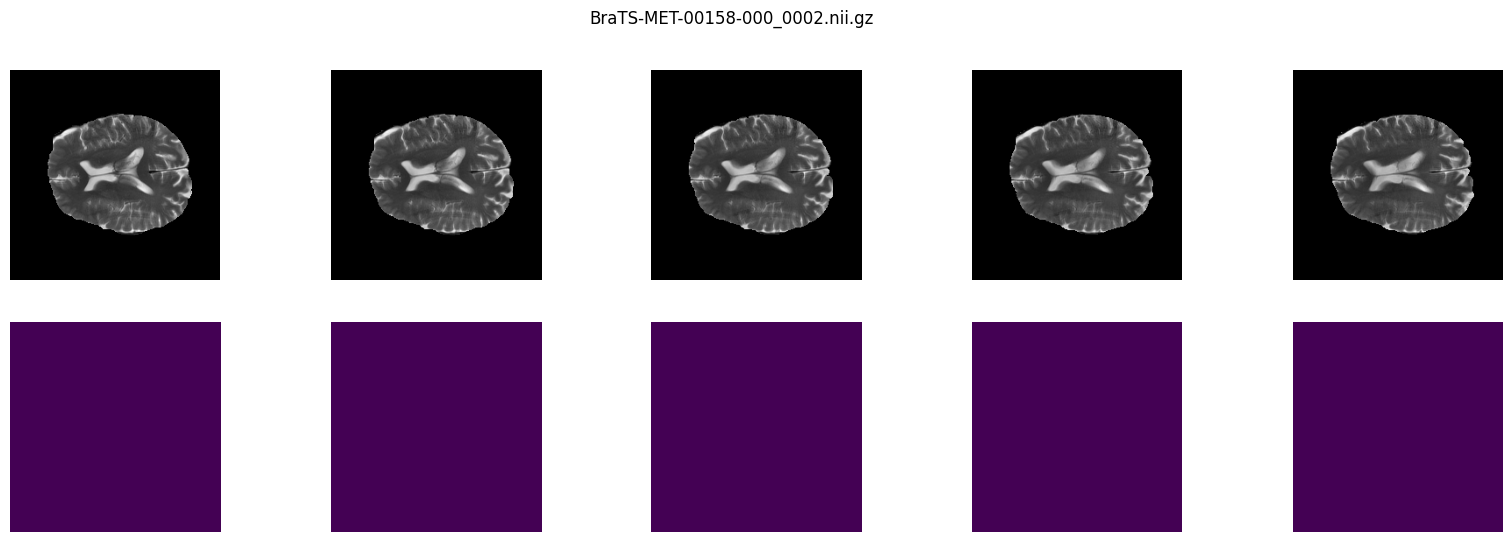

In [ ]:
# Quick Visualization of a Random Training Slice

import random, numpy as np, nibabel as nib, matplotlib.pyplot as plt, os

rand_img = random.choice(os.listdir(IMG_TR))
case_id  = rand_img.split('_')[0]
img_3d   = nib.load(os.path.join(IMG_TR, rand_img)).get_fdata()
lbl_3d   = nib.load(os.path.join(LBL_TR, f"{case_id}.nii.gz")).get_fdata()

z_start, z_end = 75, 80
img_slab = img_3d[:,:,z_start:z_end]
lbl_slab = lbl_3d[:,:,z_start:z_end]

fig, axes = plt.subplots(2, img_slab.shape[2], figsize=(20, 6))
for idx in range(img_slab.shape[2]):
    axes[0,idx].imshow(img_slab[:,:,idx], cmap='gray'); axes[0,idx].axis('off')
    axes[1,idx].imshow(lbl_slab[:,:,idx]);              axes[1,idx].axis('off')
axes[0,0].set_ylabel('Image'); axes[1,0].set_ylabel('Label')
plt.suptitle(rand_img)
plt.show()


In [ ]:
%%bash
# Overwrite configs/Brats/decoder_only.yaml per Paper's Hyperparameters
cat > 3D-TransUNet/configs/Brats/decoder_only.yaml <<'YAML'
network: 3d_fullres
network_trainer: nnUNetTrainerV2_HD95
task: Task180_BraTSMet
fold: 0
model: Generic_TransUNet_max_ppbp
config: ""

model_params:
  vit_depth: 12
  vit_hidden_size: 768
  vit_mlp_dim: 3072
  vit_num_heads: 12
  is_fam: False
  is_max: False
  is_max_ms: False
  is_max_ms_fpn: False
  is_max_bottleneck_transformer: False
  is_max_ds: False
  is_max_hungarian: False
  is_max_cls: False
  is_masked_attn: False
  point_rend: False

batch_size: 4
max_num_epochs: 80
initial_lr: 3.0e-4
weight_decay: 1.0e-2
lrschedule: cosine
warmup_epochs: 20
optimizer: adamw
npz: True
valbest: True
val_final: False
resume: ""
disable_ds: False
deterministic: False
fp32: False
layer_decay: 1.0
YAML


In [ ]:
%%bash
# Drop‑in Replacement of nnUNetTrainerV2.py ──
cat > 3D-TransUNet/nn_transunet/trainer/nnUNetTrainerV2.py <<'PY'
# Copyright 2020 Division of Medical Image Computing, German Cancer Research
# Center (DKFZ), Heidelberg, Germany
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



from __future__ import annotations

from collections import OrderedDict
from inspect import signature
from typing import Tuple, Dict, Any

import numpy as np
import torch
import torch.nn.functional as F
from batchgenerators.utilities.file_and_folder_operations import *
from sklearn.model_selection import KFold
from torch import nn
from torch.cuda.amp import autocast
from torch.optim.lr_scheduler import CosineAnnealingLR

from ..data.data_augmentation_moreDA import get_moreDA_augmentation
from ..data.dataset_loading import unpack_dataset
from ..data.default_data_augmentation import (
    default_2D_augmentation_params,
    default_3D_augmentation_params,
    get_patch_size,
)
from ..networks.nnunet_model import Generic_UNet
from ..trainer.loss_functions import MultipleOutputLoss2
from ..trainer.network_trainer import maybe_to_torch, to_cuda
from ..trainer.nnUNetTrainer import nnUNetTrainer

# ---------------------------------------------------------------------
# Helper functions and weight initializers
# ---------------------------------------------------------------------

softmax_helper = lambda x: F.softmax(x, 1)


def poly_lr(epoch: int, max_epochs: int, initial_lr: float, exponent: float = 0.9):
    """Poly learning‑rate decay (as in the original nn‑U‑Net paper)."""
    return initial_lr * (1 - epoch / float(max_epochs)) ** exponent


class InitWeights_He:
    def __init__(self, neg_slope: float = 1e-2):
        self.neg_slope = neg_slope

    def __call__(self, module):
        if isinstance(
            module,
            (
                nn.Conv3d,
                nn.Conv2d,
                nn.ConvTranspose2d,
                nn.ConvTranspose3d,
            ),
        ):
            module.weight = nn.init.kaiming_normal_(module.weight, a=self.neg_slope)
            if module.bias is not None:
                module.bias = nn.init.constant_(module.bias, 0.0)


class InitWeights_XavierUniform:
    def __init__(self, gain: float = 1.0):
        self.gain = gain

    def __call__(self, module):
        if isinstance(
            module,
            (
                nn.Conv3d,
                nn.Conv2d,
                nn.ConvTranspose2d,
                nn.ConvTranspose3d,
            ),
        ):
            module.weight = nn.init.xavier_uniform_(module.weight, self.gain)
            if module.bias is not None:
                module.bias = nn.init.constant_(module.bias, 0.0)


# ---------------------------------------------------------------------
# Trainer
# ---------------------------------------------------------------------


class nnUNetTrainerV2(nnUNetTrainer):
    """TransUNet‑aware extension of Fabian Isensee’s nnUNetTrainerV2."""

    # -----------------------------------------------------------------
    # constructor
    # -----------------------------------------------------------------
    def __init__(
        self,
        plans_file: str,
        fold: int | str,
        output_folder: str | None = None,
        dataset_directory: str | None = None,
        batch_dice: bool = True,
        stage: int | None = None,
        unpack_data: bool = True,
        deterministic: bool = True,
        fp16: bool = False,
        input_size: Tuple[int, int, int] = (64, 160, 160),
        args: Any | None = None,
    ):
        super().__init__(
            plans_file,
            fold,
            output_folder,
            dataset_directory,
            batch_dice,
            stage,
            unpack_data,
            deterministic,
            fp16,
        )

        # CLI / Hydra arguments -------------------------------------------------
        self.model_params: Dict[str, Any] = getattr(args, "model_params", {})
        self.input_size: Tuple[int, int, int] = input_size

        # sensible defaults for stand‑alone training
        self.model: str = args.model if args else "Generic_TransUNet_max_ppbp"
        self.resume: str = args.resume if args else ""
        self.disable_ds: bool = args.disable_ds if args else False
        self.max_num_epochs: int = args.max_num_epochs if args else 1_000
        self.initial_lr: float = args.initial_lr if args else 1e-3
        self.args = args

        # misc nn‑U‑Net bookkeeping
        self.save_every: int = 1
        self.deep_supervision_scales = None
        self.ds_loss_weights = None
        self.pin_memory: bool = True

    # -----------------------------------------------------------------
    # data‑augmentation parameters
    # -----------------------------------------------------------------
    def setup_DA_params(self):
        # deep‑supervision scales
        self.deep_supervision_scales = [[1, 1, 1]] + list(
            list(i)
            for i in 1
            / np.cumprod(np.vstack(self.net_num_pool_op_kernel_sizes), axis=0)
        )[:-1]

        if self.threeD:
            self.data_aug_params = default_3D_augmentation_params
            self.data_aug_params["rotation_x"] = (
                -30.0 / 360 * 2 * np.pi,
                30.0 / 360 * 2 * np.pi,
            )
            self.data_aug_params["rotation_y"] = (
                -30.0 / 360 * 2 * np.pi,
                30.0 / 360 * 2 * np.pi,
            )
            self.data_aug_params["rotation_z"] = (
                -30.0 / 360 * 2 * np.pi,
                30.0 / 360 * 2 * np.pi,
            )
            if self.do_dummy_2D_aug:
                self.data_aug_params["dummy_2D"] = True
                self.print_to_log_file("Using dummy2D data‑augmentation")
                for k in ("elastic_deform_alpha", "elastic_deform_sigma", "rotation_x"):
                    self.data_aug_params[k] = default_2D_augmentation_params[k]
        else:
            self.do_dummy_2D_aug = False
            if max(self.patch_size) / min(self.patch_size) > 1.5:
                default_2D_augmentation_params["rotation_x"] = (
                    -15.0 / 360 * 2 * np.pi,
                    15.0 / 360 * 2 * np.pi,
                )
            self.data_aug_params = default_2D_augmentation_params

        self.data_aug_params["mask_was_used_for_normalization"] = self.use_mask_for_norm

        # patch‑size calculation for spatial‑TF
        if self.do_dummy_2D_aug:
            self.basic_generator_patch_size = get_patch_size(
                self.patch_size[1:],
                self.data_aug_params["rotation_x"],
                self.data_aug_params["rotation_y"],
                self.data_aug_params["rotation_z"],
                self.data_aug_params["scale_range"],
            )
            self.basic_generator_patch_size = np.array(
                [self.patch_size[0]] + list(self.basic_generator_patch_size)
            )
        else:
            self.basic_generator_patch_size = get_patch_size(
                self.patch_size,
                self.data_aug_params["rotation_x"],
                self.data_aug_params["rotation_y"],
                self.data_aug_params["rotation_z"],
                self.data_aug_params["scale_range"],
            )

        # additional tweaks
        self.data_aug_params["scale_range"] = (0.7, 1.4)
        self.data_aug_params["do_elastic"] = False
        self.data_aug_params["selected_seg_channels"] = [0]
        self.data_aug_params["patch_size_for_spatialtransform"] = self.patch_size
        # fewer cached patches → lower RAM & threading overhead
        self.data_aug_params["num_cached_per_thread"] = 1

    # -----------------------------------------------------------------
    # initialize (overrides parent)
    # -----------------------------------------------------------------
    def initialize(self, training: bool = True, force_load_plans: bool = False):
        if self.was_initialized:
            self.print_to_log_file("Already initialized — skipping re‑init.")
            return

        maybe_mkdir_p(self.output_folder)
        if force_load_plans or self.plans is None:
            self.load_plans_file()
        self.process_plans(self.plans)
        self.setup_DA_params()

        # -----------------------------------------------------------------
        # deep‑supervision loss weights
        # -----------------------------------------------------------------
        net_numpool = len(self.net_num_pool_op_kernel_sizes)
        weights = np.array([1 / (2**i) for i in range(net_numpool)])
        mask = np.array(
            [True] + [True if i < net_numpool - 1 else False for i in range(1, net_numpool)]
        )
        weights[~mask] = 0
        weights /= weights.sum()
        self.ds_loss_weights = weights

        if self.disable_ds:
            print("Deep supervision DISABLED")
            self.ds_loss_weights[0] = 1.0
            self.ds_loss_weights[1:] = 0.0
            from ..trainer.loss_functions import DC_and_CE_loss

            self.loss = DC_and_CE_loss(
                {"batch_dice": self.batch_dice, "smooth": 1e-5, "do_bg": False}, {}
            )
        else:
            self.loss = MultipleOutputLoss2(self.loss, self.ds_loss_weights)

        # -----------------------------------------------------------------
        # dataset paths & generators
        # -----------------------------------------------------------------
        self.folder_with_preprocessed_data = join(
            self.dataset_directory, f"{self.plans['data_identifier']}_stage{self.stage}"
        )
        if training:
            self.dl_tr, self.dl_val = self.get_basic_generators()

            if self.unpack_data:
                print("Unpacking dataset …")
                unpack_dataset(self.folder_with_preprocessed_data)
                print("Done.")
            else:
                print("Not unpacking — may incur I/O overhead.")

            # Dynamic kwargs for old/new nnU‑Net APIs
            _gmda_kwargs: Dict[str, Any] = dict(
                deep_supervision_scales=self.deep_supervision_scales,
                pin_memory=self.pin_memory,
                use_nondetMultiThreadedAugmenter=False,
            )
            sig = signature(get_moreDA_augmentation)
            if "num_threads_in_multithreaded" in sig.parameters:  # nnU‑Net ≤ 1.7.x
                _gmda_kwargs["num_threads_in_multithreaded"] = 2
            elif "num_processes" in sig.parameters:  # nnUNet‑v2
                _gmda_kwargs["num_processes"] = 2

            self.tr_gen, self.val_gen = get_moreDA_augmentation(
                self.dl_tr,
                self.dl_val,
                self.data_aug_params["patch_size_for_spatialtransform"],
                self.data_aug_params,
                **_gmda_kwargs,
            )

            # quick sanity‑check
            sample = next(self.tr_gen)
            print(
                f"Sample batch: data {sample['data'].shape}, "
                f"target {[t.shape for t in sample['target']] if isinstance(sample['target'], list) else sample['target'].shape}"
            )

        # -----------------------------------------------------------------
        # network + optimizer
        # -----------------------------------------------------------------
        self.initialize_network()
        self.initialize_optimizer_and_scheduler()
        self.was_initialized = True

    # -----------------------------------------------------------------
    # network construction
    # -----------------------------------------------------------------
    def initialize_network(self):
        if not self.model.startswith("Generic"):
            raise NotImplementedError("Only Generic_* models are supported.")

        # -----------------------------------------------------------------
        # conv / norm / dropout ops
        # -----------------------------------------------------------------
        if self.threeD:
            conv_op = nn.Conv3d
            dropout_op = nn.Dropout3d
            norm_op = nn.InstanceNorm3d
        else:
            conv_op = nn.Conv2d
            dropout_op = nn.Dropout2d
            norm_op = nn.InstanceNorm2d

        norm_op_kwargs = {"eps": 1e-5, "affine": True}
        dropout_op_kwargs = {"p": 0.0, "inplace": True}
        net_nonlin = nn.LeakyReLU
        net_nonlin_kwargs = {"negative_slope": 1e-2, "inplace": True}
        do_ds = not self.disable_ds

        # -----------------------------------------------------------------
        # patch‑size reconciliation
        # -----------------------------------------------------------------
        available_keys = list(self.plans["plans_per_stage"].keys())
        print(f"Available stages in plans_per_stage: {available_keys}")
        resolution_index = 1 if 1 in available_keys else available_keys[0]
        patch_size_from_plans = self.plans["plans_per_stage"][resolution_index][
            "patch_size"
        ]
        print(f"→ Using patch_size {patch_size_from_plans} from plans")

        # scrub conflicting CLI params
        model_params = dict(self.model_params)  # shallow copy
        for key in ("patch_size", "img_size"):
            if key in model_params:
                print(f"Warning: ignoring CLI `{key}={model_params[key]}` "
                      f"in favour of plans.")
                model_params.pop(key)

        # -----------------------------------------------------------------
        # instantiate chosen architecture
        # -----------------------------------------------------------------
        if self.model == "Generic_TransUNet_max_ppbp":
            from ..networks.transunet3d_model import Generic_TransUNet_max_ppbp

            self.network = Generic_TransUNet_max_ppbp(
                self.num_input_channels,
                self.base_num_features,
                self.num_classes,
                len(self.net_num_pool_op_kernel_sizes),
                self.conv_per_stage,
                2,  # deep‑supervision skip factor
                conv_op,
                norm_op,
                norm_op_kwargs,
                dropout_op,
                dropout_op_kwargs,
                net_nonlin,
                net_nonlin_kwargs,
                do_ds,
                False,  # nondet BN
                lambda x: x,  # no custom nonlin
                InitWeights_He(1e-2),
                self.net_num_pool_op_kernel_sizes,
                self.net_conv_kernel_sizes,
                False,
                True,
                convolutional_upsampling=(
                    False
                    if ("is_fam" in model_params and model_params["is_fam"])
                    else True
                ),
                patch_size=patch_size_from_plans,
                **model_params,
            )
        else:
            raise NotImplementedError(self.model)

        if torch.cuda.is_available():
            self.network.cuda()
        self.network.inference_apply_nonlin = softmax_helper

    # -----------------------------------------------------------------
    # optimizer + LR scheduler
    # -----------------------------------------------------------------
    def initialize_optimizer_and_scheduler(self):
        if getattr(self, "lrschedule", "poly") == "cosine":
            self.optimizer = torch.optim.AdamW(
                self.network.parameters(),
                lr=self.initial_lr,
                weight_decay=self.weight_decay,
                betas=(0.9, 0.999),
            )
            self.lr_scheduler = CosineAnnealingLR(
                self.optimizer,
                T_max=self.max_num_epochs,
                eta_min=1e-6,
            )
            self.print_to_log_file("Initialized AdamW + cosine‑annealing scheduler")
        else:
            super().initialize_optimizer_and_scheduler()

    def maybe_update_lr(self, epoch: int | None = None):
        ep = self.epoch + 1 if epoch is None else epoch
        self.optimizer.param_groups[0]["lr"] = poly_lr(
            ep, self.max_num_epochs, self.initial_lr, 0.9
        )
        self.print_to_log_file(
            "lr:",
            np.round(self.optimizer.param_groups[0]["lr"], decimals=6),
        )

    # -----------------------------------------------------------------
    # corrected run_iteration
    # -----------------------------------------------------------------
    def run_iteration(
        self,
        data_generator,
        do_backprop: bool = True,
        run_online_evaluation: bool = False,
    ):
        data_dict = next(data_generator)
        data = data_dict["data"]
        target = data_dict["target"]

        # diagnostics
        print(f"Input data shape  : {data.shape}")
        print(f"Target type       : {type(target)}")

        data = maybe_to_torch(data)
        target = maybe_to_torch(target)
        if torch.cuda.is_available():
            data = to_cuda(data)
            target = to_cuda(target)

        self.optimizer.zero_grad()

        # -------------------------------------------------------------
        # fp16 branch
        # -------------------------------------------------------------
        if self.fp16:
            with autocast():
                output = self.network(data)
                del data

                # prepare loss inputs
                if isinstance(output, (list, tuple)):
                    output_for_loss = output if not self.disable_ds else output[0]
                elif isinstance(output, dict):
                    output_for_loss = output.get(
                        "output", output.get("seg", output)
                    )
                else:
                    output_for_loss = output

                if isinstance(target, (list, tuple)):
                    target_for_loss = target if not self.disable_ds else target[0]
                else:
                    target_for_loss = target

                print(
                    f"Output for loss: "
                    f"{output_for_loss.shape if isinstance(output_for_loss, torch.Tensor) else type(output_for_loss)}"
                )
                print(
                    f"Target for loss: "
                    f"{target_for_loss.shape if isinstance(target_for_loss, torch.Tensor) else type(target_for_loss)}"
                )

                l = self.loss(output_for_loss, target_for_loss)

            if do_backprop:
                self.amp_grad_scaler.scale(l).backward()
                self.amp_grad_scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.network.parameters(), 12)
                self.amp_grad_scaler.step(self.optimizer)
                self.amp_grad_scaler.update()

        # -------------------------------------------------------------
        # full‑precision branch
        # -------------------------------------------------------------
        else:
            output = self.network(data)
            del data

            if isinstance(output, (list, tuple)):
                output_for_loss = output if not self.disable_ds else output[0]
            elif isinstance(output, dict):
                output_for_loss = output.get("output", output.get("seg", output))
            else:
                output_for_loss = output

            if isinstance(target, (list, tuple)):
                target_for_loss = target if not self.disable_ds else target[0]
            else:
                target_for_loss = target

            print(
                f"Output for loss: "
                f"{output_for_loss.shape if isinstance(output_for_loss, torch.Tensor) else type(output_for_loss)}"
            )
            print(
                f"Target for loss: "
                f"{target_for_loss.shape if isinstance(target_for_loss, torch.Tensor) else type(target_for_loss)}"
            )

            l = self.loss(output_for_loss, target_for_loss)

            if do_backprop:
                l.backward()
                torch.nn.utils.clip_grad_norm_(self.network.parameters(), 12)
                self.optimizer.step()

        # -------------------------------------------------------------
        # bookkeeping
        # -------------------------------------------------------------
        loss_val = l.detach().cpu().numpy()
        print(f"Iteration loss: {loss_val:.6f}")

        if run_online_evaluation:
            output_eval = output[0] if isinstance(output, (list, tuple)) else output
            target_eval = target[0] if isinstance(target, (list, tuple)) else target

            if isinstance(output_eval, dict):
                output_eval = output_eval.get("output", output_eval.get("seg", output_eval))
            if not isinstance(output_eval, torch.Tensor):
                raise ValueError(f"Expected tensor, got {type(output_eval)}")
            if not isinstance(target_eval, torch.Tensor):
                raise ValueError(f"Expected tensor, got {type(target_eval)}")

            if output_eval.dim() != 5:
                output_eval = output_eval.unsqueeze(0)
            if target_eval.dim() == 4:
                target_eval = target_eval.unsqueeze(1)

            print(f"Eval output shape: {output_eval.shape}")
            print(f"Eval target shape: {target_eval.shape}")

            self.run_online_evaluation(output_eval, target_eval)

        del target
        return loss_val

    # -----------------------------------------------------------------
    # do_split, validate, prediction, DA params, on_epoch_end,
    # run_training
    # -----------------------------------------------------------------

    def do_split(self):
        """
        Default = five‑fold CV.  Falls back to deterministic 80:20 if the
        requested fold index is out of range.  You can override by placing
        a custom ``splits_final.pkl`` in the pre‑processed data folder.
        """
        if isinstance(self.fold, str) and self.fold.startswith("all"):
            if self.fold == "all":
                tr_keys = val_keys = list(self.dataset.keys())
            elif "tr" in self.fold:
                np.random.seed(12345)
                all_keys = list(self.dataset.keys())
                np.random.shuffle(all_keys)
                proportion = float(self.fold.split("tr")[-1])
                assert proportion < 1.0
                cur = int(len(all_keys) * proportion)
                tr_keys = val_keys = all_keys[:cur]
        else:
            splits_file = join(self.dataset_directory, "splits_final.pkl")
            if not isfile(splits_file):
                self.print_to_log_file("Creating new 5‑fold split …")
                splits = []
                keys_sorted = np.sort(list(self.dataset.keys()))
                kfold = KFold(n_splits=5, shuffle=True, random_state=12345)
                for train_idx, test_idx in kfold.split(keys_sorted):
                    splits.append(
                        OrderedDict(
                            train=np.array(keys_sorted)[train_idx],
                            val=np.array(keys_sorted)[test_idx],
                        )
                    )
                save_pickle(splits, splits_file)
            else:
                self.print_to_log_file("Using existing split file:", splits_file)
                splits = load_pickle(splits_file)
                self.print_to_log_file(f"Split file contains {len(splits)} folds.")

            self.print_to_log_file(f"Desired fold: {self.fold}")
            if self.fold < len(splits):
                tr_keys = splits[self.fold]["train"]
                val_keys = splits[self.fold]["val"]
                self.print_to_log_file(
                    f"→ {len(tr_keys)} training / {len(val_keys)} validation cases."
                )
            else:
                self.print_to_log_file(
                    f"Fold {self.fold} not found — creating seeded 80:20 split."
                )
                rnd = np.random.RandomState(seed=12345 + self.fold)
                keys = np.sort(list(self.dataset.keys()))
                idx_tr = rnd.choice(len(keys), int(len(keys) * 0.8), replace=False)
                idx_val = [i for i in range(len(keys)) if i not in idx_tr]
                tr_keys = [keys[i] for i in idx_tr]
                val_keys = [keys[i] for i in idx_val]

        # build OrderedDicts expected by nnU‑Net
        self.dataset_tr = OrderedDict((k, self.dataset[k]) for k in sorted(tr_keys))
        self.dataset_val = OrderedDict((k, self.dataset[k]) for k in sorted(val_keys))

    # … validate() and predict_preprocessed_data_return_seg_and_softmax()
    #   are unchanged, except for disabling ds during inference

    def validate(
        self,
        do_mirroring: bool = True,
        use_sliding_window: bool = True,
        step_size: float = 0.5,
        save_softmax: bool = True,
        use_gaussian: bool = True,
        overwrite: bool = True,
        validation_folder_name: str = "validation_raw",
        debug: bool = False,
        all_in_gpu: bool = False,
        segmentation_export_kwargs: dict | None = None,
        run_postprocessing_on_folds: bool = True,
    ):
        ds = self.network.do_ds
        self.network.do_ds = False
        ret = super().validate(
            do_mirroring,
            use_sliding_window,
            step_size,
            save_softmax,
            use_gaussian,
            overwrite,
            validation_folder_name,
            debug,
            all_in_gpu,
            segmentation_export_kwargs,
            run_postprocessing_on_folds,
        )
        self.network.do_ds = ds
        return ret

    def predict_preprocessed_data_return_seg_and_softmax(
        self,
        data: np.ndarray,
        do_mirroring: bool = True,
        mirror_axes: Tuple[int] | None = None,
        use_sliding_window: bool = True,
        step_size: float = 0.5,
        use_gaussian: bool = True,
        pad_border_mode: str = "constant",
        pad_kwargs: dict | None = None,
        all_in_gpu: bool = False,
        verbose: bool = True,
        mixed_precision: bool = True,
    ) -> Tuple[np.ndarray, np.ndarray]:
        ds = self.network.do_ds
        self.network.do_ds = False
        ret = super().predict_preprocessed_data_return_seg_and_softmax(
            data,
            do_mirroring,
            mirror_axes,
            use_sliding_window,
            step_size,
            use_gaussian,
            pad_border_mode,
            pad_kwargs,
            all_in_gpu,
            verbose,
            mixed_precision,
        )
        self.network.do_ds = ds
        return ret

    # -----------------------------------------------------------------
    # epoch‑level hooks
    # -----------------------------------------------------------------
    def on_epoch_end(self):
        super().on_epoch_end()
        continue_training = self.epoch < self.max_num_epochs
        if self.epoch == 100 and self.all_val_eval_metrics[-1] == 0:
            self.optimizer.param_groups[0]["momentum"] = 0.95
            self.network.apply(InitWeights_He(1e-2))
            self.print_to_log_file(
                "Val Dice still 0 at epoch 100 → momentum → 0.95, re‑init weights."
            )
        return continue_training

    def run_training(self):
        self.maybe_update_lr(self.epoch)
        ds = self.network.do_ds
        if not self.disable_ds:
            self.network.do_ds = True

        print(f"Starting epoch {self.epoch + 1}/{self.max_num_epochs}")
        ret = super().run_training()
        self.network.do_ds = ds
        return ret

PY


In [ ]:
%%bash
# Create the HD95 trainer class
cat > 3D-TransUNet/nn_transunet/trainer/nnUNetTrainerV2_HD95.py <<'PY'
from __future__ import annotations
import numpy as np
import torch
from medpy.metric.binary import hd95 as _hd95
from .nnUNetTrainerV2 import nnUNetTrainerV2

class nnUNetTrainerV2_HD95(nnUNetTrainerV2):
    """
    Same as nnUNetTrainerV2, but also computes & logs HD95 (mm) for ET/TC/WT
    during online validation each epoch. No saved predictions needed.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.online_eval_foreground_hd95 = []
        self.all_val_eval_hd95 = []
        self._eval_voxelspacing = None

    def _get_eval_spacing(self):
        if self._eval_voxelspacing is None:
            try:
                s = self.plans['plans_per_stage'][self.stage]['current_spacing']
                self._eval_voxelspacing = tuple(float(x) for x in s[:3])
            except Exception:
                self._eval_voxelspacing = (1.0, 1.0, 1.0)
        return self._eval_voxelspacing

    @staticmethod
    def _safe_hd95(pred_mask: np.ndarray, ref_mask: np.ndarray, spacing):
        p, r = bool(pred_mask.any()), bool(ref_mask.any())
        if not p and not r:
            return np.nan
        if p and r:
            return float(_hd95(pred_mask, ref_mask, voxelspacing=spacing))
        return np.inf

    def _hd95_regions(self, seg_pred: np.ndarray, gt: np.ndarray, spacing):
        # BraTS regions: ET=4, TC={1,4}, WT={1,2,4}
        et_p, et_r = (seg_pred == 4), (gt == 4)
        tc_p, tc_r = ((seg_pred == 1) | (seg_pred == 4)), ((gt == 1) | (gt == 4))
        wt_p, wt_r = ((seg_pred == 1) | (seg_pred == 2) | (seg_pred == 4)), ((gt == 1) | (gt == 2) | (gt == 4))
        return np.array([
            self._safe_hd95(et_p, et_r, spacing),
            self._safe_hd95(tc_p, tc_r, spacing),
            self._safe_hd95(wt_p, wt_r, spacing),
        ], dtype=np.float32)

    def run_online_evaluation(self, output, target):
        # keep nnU-Net's Dice computation
        super().run_online_evaluation(output, target)

        # hard labels for prediction
        if isinstance(output, dict):
            output = output.get("output", output.get("seg", output))
        if output.dim() != 5:  # expect (B, C, Z, Y, X)
            output = output.unsqueeze(0) if output.dim() == 4 else output
        pred_lbl = torch.argmax(output, dim=1).detach().cpu().numpy()

        # target as (B, Z, Y, X)
        if target.dim() == 4:
            target = target.unsqueeze(1)
        gt = target[:, 0].detach().cpu().numpy()

        spacing = self._get_eval_spacing()
        batch_vals = [self._hd95_regions(pred_lbl[b], gt[b], spacing)
                      for b in range(pred_lbl.shape[0])]
        self.online_eval_foreground_hd95.append(np.vstack(batch_vals))  # (B, 3)

    def on_epoch_end(self):
        cont = super().on_epoch_end()

        # aggregate HD95 across all val batches of this epoch
        if len(self.online_eval_foreground_hd95):
            hd = np.vstack(self.online_eval_foreground_hd95)  # (N, 3)
            hd[np.isinf(hd)] = np.nan
            means = np.nanmean(hd, axis=0).astype(np.float32)
        else:
            means = np.array([np.nan, np.nan, np.nan], dtype=np.float32)

        self.all_val_eval_hd95.append(means)
        self.print_to_log_file(
            "Average global foreground HD95 (mm): "
            f"[np.float32({means[0]:.6f}), np.float32({means[1]:.6f}), np.float32({means[2]:.6f})]"
        )
        self.online_eval_foreground_hd95 = []  # reset
        return cont
PY


In [ ]:
# Make Python See the Repo without Installing It

import sys, os, pathlib

TRANSUNET_ROOT = '/content/drive/MyDrive/nnunet_colab/3D-TransUNet'
assert pathlib.Path(TRANSUNET_ROOT).is_dir(), "path does not exist!"

if TRANSUNET_ROOT not in sys.path:
    sys.path.append(TRANSUNET_ROOT)
    os.environ['PYTHONPATH'] = os.environ.get('PYTHONPATH','') + ':' + TRANSUNET_ROOT

import nn_transunet
print("D‑TransUNet is now importable.")

D‑TransUNet is now importable.


In [ ]:
import os, pathlib

ROOT = pathlib.Path('/content/drive/MyDrive/nnunet_colab')
RAW_BASE = ROOT/'nnUNet_raw_data_base'

os.environ['nnUNet_codebase']      = str(RAW_BASE/'nnUNet_raw_data')   # ← new
os.environ['nnUNet_raw_data_base'] = str(RAW_BASE)
os.environ['nnUNet_preprocessed']  = str(ROOT/'preprocessed')
os.environ['RESULTS_FOLDER']       = str(ROOT/'nnUNet_trained_models')

for p in (RAW_BASE, ROOT/'preprocessed', ROOT/'nnUNet_trained_models'):
    p.mkdir(parents=True, exist_ok=True)

print("Environment variables now:")
for k in ("nnUNet_codebase","nnUNet_raw_data_base",
          "nnUNet_preprocessed","RESULTS_FOLDER"):
    print(f"  {k} = {os.environ[k]}")


Environment variables now:
  nnUNet_codebase = /content/drive/MyDrive/nnunet_colab/nnUNet_raw_data_base/nnUNet_raw_data
  nnUNet_raw_data_base = /content/drive/MyDrive/nnunet_colab/nnUNet_raw_data_base
  nnUNet_preprocessed = /content/drive/MyDrive/nnunet_colab/preprocessed
  RESULTS_FOLDER = /content/drive/MyDrive/nnunet_colab/nnUNet_trained_models


In [ ]:
%%bash
cat > 3D-TransUNet/train.py <<'PY'

import argparse, os, pathlib, subprocess, sys, yaml, torch
from nnunet.paths import default_plans_identifier
from nnunet.run.load_pretrained_weights import load_pretrained_weights
from nn_transunet.default_configuration import get_default_configuration

def ensure_local_preprocessed() -> None:
    src = pathlib.Path("/content/drive/MyDrive/nnunet_colab/preprocessed")
    dst = pathlib.Path("/content/nnunet_preprocessed_local")
    if not src.exists():
        sys.exit(f"[FATAL] expected source dir {src} is missing – abort.")
    if not dst.exists():
        print(f"↪ Copying dataset to fast local disk …")
        dst.mkdir(parents=True, exist_ok=True)
        subprocess.run(["rsync", "-ah", "--info=progress2", f"{src}/", f"{dst}/"], check=True)
        print("✓ Dataset copied.")
    else:
        print(f"✓ Local dataset cache already present → {dst}")
    os.environ["nnUNet_preprocessed"] = str(dst)

def cli() -> argparse.Namespace:
    p = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    p.add_argument("--network", default="3d_fullres")
    p.add_argument("--network_trainer", default="nnUNetTrainerV2_HD95")  # default to our trainer
    p.add_argument("--task", default="Task180_BraTSMet")
    p.add_argument("--fold", default="0")
    p.add_argument("--resume", default="")
    p.add_argument("-p", default=default_plans_identifier)
    p.add_argument("--validation_only", action="store_true")
    p.add_argument("--disable_ds", action="store_true")
    p.add_argument("--npz", action="store_true")
    p.add_argument("--valbest", action="store_true")
    p.add_argument("--vallatest", action="store_true")
    p.add_argument("--fp32", action="store_true")
    p.add_argument("--model", default="Generic_TransUNet_max_ppbp")
    p.add_argument("--config", default="")
    p.add_argument("--batch_size", type=int, default=1)
    p.add_argument("--max_num_epochs", type=int, default=1000)
    p.add_argument("--initial_lr", type=float, default=1e-3)
    p.add_argument("--weight_decay", type=float, default=3e-5)
    p.add_argument("--lrschedule", default="poly")
    p.add_argument("--model_params", type=dict, default={})

    args_partial, _ = p.parse_known_args()
    if args_partial.config and os.path.isfile(args_partial.config):
        with open(args_partial.config) as f:
            config = yaml.safe_load(f)
            if 'model_params' in config and 'patch_size' in config['model_params']:
                print("Removing 'patch_size' from model_params in config to avoid duplication")
                config['model_params'].pop('patch_size')
            p.set_defaults(**config)
    args, _ = p.parse_known_args()
    if isinstance(args.fold, str) and args.fold.isdigit():
        args.fold = int(args.fold)
    return args

def build_trainer(args):
    try:
        plans, out_dir, ds_dir, batch_dice, stage, trainer_cls = \
            get_default_configuration(args.network, args.task, args.network_trainer, args.p)
    except KeyError as e:
        if str(e).strip("'") == "nnUNetTrainerV2_HD95":
            print("Note: registering custom trainer 'nnUNetTrainerV2_HD95' via fallback.")
            from nn_transunet.trainer.nnUNetTrainerV2_HD95 import nnUNetTrainerV2_HD95
            plans, out_dir, ds_dir, batch_dice, stage, _ = \
                get_default_configuration(args.network, args.task, "nnUNetTrainerV2", args.p)
            trainer_cls = nnUNetTrainerV2_HD95
        else:
            raise

    return trainer_cls(
        plans, args.fold,
        output_folder=out_dir,
        dataset_directory=ds_dir,
        batch_dice=batch_dice,
        stage=stage,
        unpack_data=True,
        deterministic=True,
        fp16=not args.fp32,
        input_size=args.model_params.get("img_size", [64, 160, 160]),
        args=args,
    )

def main() -> None:
    ensure_local_preprocessed()
    os.environ.setdefault("nnUNet_raw_data_base", "/content/drive/MyDrive/nnunet_colab/nnUNet_raw_data_base")
    os.environ.setdefault("RESULTS_FOLDER", "/content/drive/MyDrive/nnunet_colab/nnUNet_trained_models")
    print("\nENV  nnUNet_preprocessed =", os.environ["nnUNet_preprocessed"])
    print("     nnUNet_raw_data_base =", os.environ["nnUNet_raw_data_base"])
    print("     RESULTS_FOLDER       =", os.environ["RESULTS_FOLDER"], "\n")

    args = cli()
    torch.backends.cudnn.benchmark = not getattr(args, "deterministic", False)

    if torch.cuda.is_available():
        print(f"GPU available: {torch.cuda.get_device_name(0)}")
        print(f"Initial GPU memory allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")

    trainer = build_trainer(args)
    trainer.initialize(training=not args.validation_only)

    if args.validation_only:
        if args.valbest:
            trainer.load_best_checkpoint(train=False)
        elif args.vallatest:
            trainer.load_latest_checkpoint(train=False)
        else:
            trainer.load_final_checkpoint(train=False)
        trainer.validate(
            save_softmax=args.npz,
            validation_folder_name="val",
            run_postprocessing_on_folds=True,
        )
        return

    if args.resume in ("auto", "local_latest"):
        trainer.load_latest_checkpoint(train=True)
    elif args.resume and os.path.isfile(args.resume):
        load_pretrained_weights(trainer.network, args.resume)

    trainer.run_training()

    if torch.cuda.is_available():
        print(f"Final GPU memory allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")

if __name__ == "__main__":
    main()
PY


In [ ]:
%%bash
# Launch 3D-TransUNet Training

export PYTHONUNBUFFERED=1

# Pick GPU 0
export CUDA_VISIBLE_DEVICES=0

# Run the training script with un-buffered mode
python -u 3D-TransUNet/train.py \
  --config 3D-TransUNet/configs/Brats/decoder_only.yaml \
  --fold 0



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

✓ Local dataset cache already present → /content/nnunet_preprocessed_local

ENV  nnUNet_preprocessed = /content/nnunet_preprocessed_local
     nnUNet_raw_data_base = /content/drive/MyDrive/nnunet_colab/nnUNet_raw_data_base
     RESULTS_FOLDER       = /content/drive/MyDrive/nnunet_colab/nnUNet_trained_models 

GPU available: NVIDIA A100-SXM4-40GB
Initial GPU memory allocated: 0.00 MB
['/content/drive/MyDrive/nnunet_colab/nnUNet_raw_data_base/nnUNet_raw_data/training/network_training'] nnUNetTrainerV2_HD95 nnunet.training.network_training
Note: registering custom trainer 'nnUNetTrainerV2_HD95' via fallback.
['/content/drive/MyDrive/

/content/drive/MyDrive/nnunet_colab/3D-TransUNet/nn_transunet/trainer/network_trainer.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.amp_grad_scaler = GradScaler()
/content/drive/MyDrive/nnunet_colab/3D-TransUNet/nn_transunet/trainer/nnUNetTrainerV2.py:454: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/content/drive/MyDrive/nnunet_colab/3D-TransUNet/nn_transunet/trainer/nnUNetTrainer.py:778: RuntimeWarning: invalid value encountered in scalar divide
  global_dc_per_class = [i for i in [2 * i / (2 * i + j + k) for i, j, k in


Mounted at /content/drive
Using log file: training_log_2025_8_11_01_01_47.txt


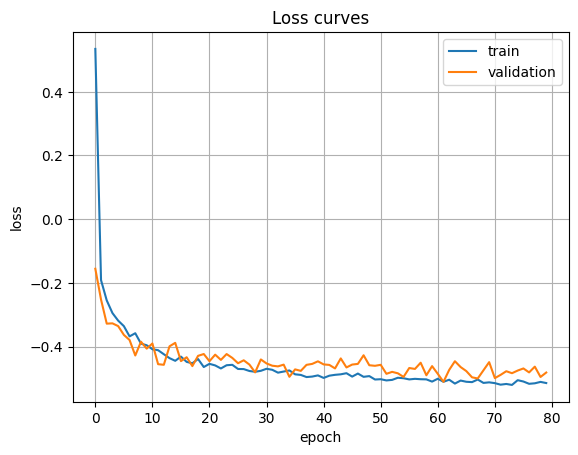

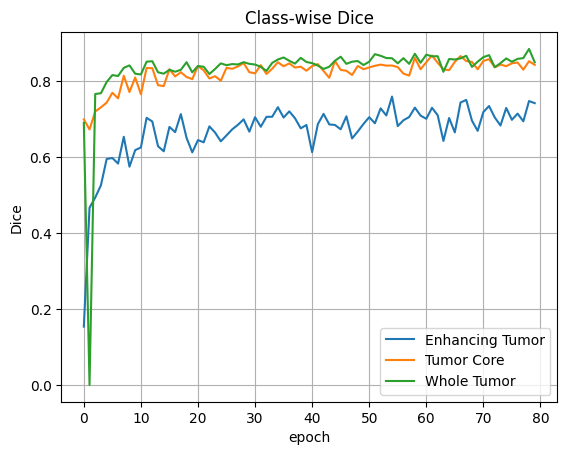

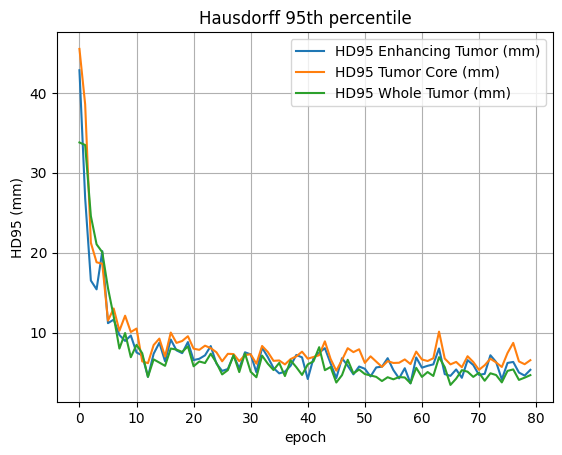

In [2]:
# Preparing the Presentation Plots

# 0 ▸ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# 1 Resolve path to fold_0
from pathlib import Path
BASE = Path('/content/drive/MyDrive')
FOLDER = (
    BASE /
    'nnunet_colab' /
    'nnUNet_trained_models' /
    'UNet_IN_NANFang' /
    'Task180_BraTSMet' /
    'nnUNetTrainerV2__nnUNetPlansv2.1' /
    'fold_0'
)

log_files = sorted(FOLDER.glob('training_log_*.txt'),
                   key=lambda p: p.stat().st_mtime)
if not log_files:
    raise FileNotFoundError(f'No “training_log_*.txt” found in:\n{FOLDER}')

latest_log = log_files[-1]
print(f'Using log file: {latest_log.name}')

# 2 Read the log
with latest_log.open('r', encoding='utf-8', errors='ignore') as fh:
    LOG_TEXT = fh.read()

# 3 Parse into a DataFrame
import re, pandas as pd, matplotlib.pyplot as plt

float_pat = r'([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)'
def take_val(key, line):
    m = re.search(rf'{key}\s*:\s*{float_pat}\s*$', line)
    return float(m.group(1)) if m else None

records, cur = [], None
for ln in LOG_TEXT.splitlines():
    # epoch header
    m = re.search(r'epoch:\s+(\d+)', ln)
    if m:
        if cur: records.append(cur)
        cur = {'epoch': int(m.group(1))}
        continue
    if cur is None:
        continue

    # losses
    for tag in ('train loss', 'validation loss'):
        v = take_val(tag, ln)
        if v is not None:
            cur[tag.replace(' ', '_')] = v
            break

    # Dice
    if 'Average global foreground Dice' in ln:
        cur.update({
            f'dice{i}': float(x)
            for i, x in enumerate(
                re.findall(r'np\.float32\(' + float_pat + r'\)', ln))
        })

    # HD95
    if 'Average global foreground HD95' in ln:
        vals = [float(x) for x in re.findall(r'np\.float32\(' + float_pat + r'\)', ln)]
        if len(vals) >= 3:
            cur['hd95_et'], cur['hd95_tc'], cur['hd95_wt'] = vals[:3]


if cur: records.append(cur)

df = (
    pd.DataFrame(records)
      .set_index('epoch')
      .sort_index()
)

# 4 Plot: Loss
plt.figure()
plt.plot(df.index, df['train_loss'], label='train')
plt.plot(df.index, df['validation_loss'], label='validation')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Loss curves')
plt.legend(); plt.grid(True)
plt.show()

# 5 Plot: Dice with clinical labels (Enhancing Tumor/Tumor Core/Whole Tumor)
plt.figure()
dice_labels = {'dice0': 'Enhancing Tumor',
               'dice1': 'Tumor Core',
               'dice2': 'Whole Tumor'}
for col, label in dice_labels.items():
    if col in df.columns:
        plt.plot(df.index, df[col], label=label)
plt.xlabel('epoch'); plt.ylabel('Dice'); plt.title('Class‑wise Dice')
plt.legend(); plt.grid(True)
plt.show()

# 6 Plot: HD95 (mm)
if {'hd95_et','hd95_tc','hd95_wt'}.issubset(df.columns):
    plt.figure()
    for col, label in zip(['hd95_et','hd95_tc','hd95_wt'],
                          ['HD95 Enhancing Tumor (mm)','HD95 Tumor Core (mm)','HD95 Whole Tumor (mm)']):
        plt.plot(df.index, df[col], label=label)
    plt.xlabel('epoch'); plt.ylabel('HD95 (mm)'); plt.title('Hausdorff 95th percentile')
    plt.legend(); plt.grid(True)
    plt.show()
